The goal of this project was to train a neural network to clone the bahviour of a human driver - a process known as behavioural cloning.  We used the Udacity car simulator to collect training data by driving the car around a track. The simulator collected data as it was driven that consisted of 320x160 pixel RGB images from a front facing camera and the associated steering wheel angle.  Once trained the model could be loaded back into the simulator to control the steering angle based on a "live" feed of camera images.

This report describes 3 failed attempts to train a model to perform this task, followed by a fourth and fifth attempt that was successful.  I then summarise key learnings from the project.

### Data Collection

My plan to generate training data was to record two laps of the track in a forward direction plus an additional two laps driven in the opposite direction.  The reason I recorded data in both directions was to balance out the left and right turns in the training data.  The track was a loop and so just recording in one direction could have biased the training data, limiting how well the model would generalise to other tracks.  

The first problem I ran into was how to drive the car!  I found controlling the simulator difficult when using the keyboard.  I managed to drive better using an xbox controller (thanks to Colin Munro for a Mac 360 Controller [available here](https://github.com/360Controller/360Controller)).

The histogram below shows the distribution of steering angles from the combined forward and backward driving data - which is reasonably symetric around zero:

![training-data-angle-distribution](resources/training-data-angle-distribution.png)

In addition to the general driving data I also recorded two laps of recovery data in the forward direction.  Recovery data is data that captures the process of recovering form veering off course.  Unlike with the general driving data, I felt that recovery data did not need to be created in both directions since I was recovering from both sides of the road and so it would be relatively balanced.    I did spend time manually cleaning the recovery data.  I found it difficult to drive to the edge and then start recording.  Instead I recorded constantly - swerving out to the edge of the road and then recovering the car.  I then edited the frames afterwards - deleting images that related to driving from the center to the edge of the road.  

I used all images (center, left and right) - making a steering angle adjustment of +/- 0.25 for the left and right images respectively.  After cleaning the recovery data I had a total of 20,697 images in my training data:

| Dataset | Images | 
| ------- | ----- | 
| 2 laps normal driving forward   | 9,684  | 
| 2 laps normal driving backward  | 6,288  | 
| 2 laps recovery driving         | 4,725  |
| Total                           | 20,697 | 

### AWS 

In order to speed up model training I decided to use AWS to spin up GPU based compute resources - specifcally a g2.2xlarge: 15 GiB memory, 1 x NVIDIA GRID GPU (Kepler GK104), 60 GB of local instance storage, 64-bit platform.  

I followed the Udacity instructions to create the AWS EC2 GPU instance.  I benefitted from $50 of credit from Amazon - thanks Amazon and Udacity!  Everything was straightforward apart from a small error in the instance name in Udacity docs [here](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/614d4728-0fad-4c9d-a6c3-23227aef8f66/concepts/f6fccba8-0009-4d05-9356-fae428b6efb4) - it incorrectly suggested installing the base image - whereas the correct one was Udacity CarND (ami-14261d03) - also the image had no carnd user as stated in the guide - it was default 'ubuntu' user.  

In total for this project I used 46 hours of AWS compute over several weeks.

### Initial Experiments (models 1 and 2)

Throughout this project I started with a variation of the NVidia architecture described [here](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/).  Compared to the NVidia architecture reduced the number of parameters and started without dropout layers - to reduce the number of parameters and to allow me to implement early stopping - rather than rely on dropout to control for over-fitting.  My first model was as follows:

[insert diagram]

Initial experiments used the full RGB images that were 160x320 pixels in size.  I used images from all 3 cameras - adjusting the steering angles for the off-center images by +0.25 for the left image and -0.25 for the right image.  The separate channels of the images were normalized to have range 0.0 - 1.0 - the normalisation was performed in the Lambda layer in the keras model.  

My first attempts at training the model utilised early stopping - with 20% of the training data randomly selected as validation data and 80% retained for training purposes.  I expected that training a model to generalise well in terms of out of sample MSE on the validation would be a good strategy.  The following function was used to split the driving log into a trainingin and validation set:

```
def split_driving_log(f, train_percent, seed=1973):
    ft = open('train_log.csv','w')
    fv = open('valid_log.csv','w')
    np.random.seed(seed)
    with open(f, 'r') as f:
        for line in f:
            if (np.random.random() <= train_percent):
                ft.write(line)
            else:
                fv.write(line)
    ft.close()
    fv.close()

```

There were also missing images for some of the entries in the driving log.  I used the following function to clean the original driving log:

```
def clean_driving_log(logfile, img_dir):
    with open(logfile,'r') as r, open('clean_log.csv','w') as w:
        reader = csv.reader(r, delimiter=',')
        writer = csv.writer(w, delimiter=',')
        for row in reader:
            img_file = img_dir + row[0]
            if (os.path.isfile(img_file)):
                writer.writerow(row)
```

To implement early stopping I needed to create two generators one to provide the images during training and one to provide the images for validation.  After cleaning and splitting log files into a training and validation set I could initialise two generators.  The training data generator selected images randomly:

```
def generator_random(n, img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for _ in range(n):
            i = np.random.randint(low=0,high=l)
            img = load_image(img_dir+f[i])
            xs.append(img)
            ys.append(y[i])
        yield (np.asarray(xs), np.asarray(ys))
```

The validation generator was different - all the images were selected to ensure that the validation error could be  compute without any addiotional randomness: 

```
def generator_all(img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for i in range(l):
            img = load_image(img_dir+f[i])
            xs.append(img)
            ys.append(y[i])
        yield (np.asarray(xs), np.asarray(ys))
```

I used an Adam optimizer since it reduced the number of hyperparameters - for all my models the learning rate was set at 0.0001.    I trained the initial model with 50 barches of size 400.  I let the model train until the validation error failed to improve for 20 epochs.  

My initial model did not perform very well - seldom being able to get around the first bend and onto the bridge!  This was a common end state:

<img src="resources/carnd-hit-bridge.png" width="300">

I tried recording specific training data for the bridge approach multiple times and adding that to training data - this was time consuming and not particularly effective - not helping me get across bridge.  I also did not find it appealing to be incrementally training the model with the patched training data - mainly because it felt a little arbitrary and hard to reproduce exactly what I did.

My experiments with early stopping were also unsatisfactory - in general I got better models (could get to the bridge) by using all the training data and just training for a fixed number of iterations.  This led me to conclude that maybe I needed a lot more data.   
I also noticed that the information in the images in the top and bottom of the image could be wasteful and have limited utility in training - the sky is not something a driver typically cares about - so why should the model?  At this point I trimmed the top 60 pixels and bottom 20 pixels off the images.

Since I was concerned about overfitting, but did not want to use early stopping, I reintroduced dropout back into the second model - I added dropout in the fully connected layer as follows:

[insert image]

My second model led to a small improvement in the performance of the car - I could now routinely make it onto bridge - but this point I hit a wall - both in terms of forward progress and quite literally on the bridge!  I tried many iterations and different training durations - but could not get further than the bridge - typically the car would come to rest on the bridge against the wall:

<img src="resources/carnd-hit-wall.png" width="300">

### Reboot and Success (models 3 and 4)term

At this point I decided to check out the Slack channel!  I had previously been hanging out on the forums - since I did not realise that there was a project specific slack channel.  I found some great approaches to this problem by [Vivek Yadav](https://chatbotslife.com/learning-human-driving-behavior-using-nvidias-neural-network-model-and-image-augmentation-80399360efee#.f4c5rlz7z) and [Mohan Karthik](https://medium.com/@mohankarthik/cloning-a-car-to-mimic-human-driving-5c2f7e8d8aff#.b17uyuekf) and decided to also adopt the image augmentation approach.  In particular:

* Trim top 60 and bottom 20 pixels off the image
* Reduce size of images to 64x64 pixels
* Randomly change the image brightness
* Apply small random lateral translations - both in X and Y direction
* Randomly flip the images

I also liked Vivek's idea to add an initial 3 1x1 filters in model to allow the model to determine the optimal combination of the RGB channels.  

My generator now calls the `generate_image()` function which performs the image augmentation:

```
def generate_image(img, y):
    
    angle = y

    X_OFFSET_RANGE = 10
    Y_OFFSET_RANGE = 10
    X_OFFSET_ANGLE = 0.2
    
    img = preprocess_image(img)
    
    bright_factor = 0.2 + (3.8 * np.random.uniform())
    img = gamma_correction(img, bright_factor)

    if (np.random.uniform() > 1.0):
        img = np.fliplr(img)
        angle = -1.0 * angle

    x_translation = (X_OFFSET_RANGE * np.random.uniform()) - (X_OFFSET_RANGE / 2)
    y_translation = (Y_OFFSET_RANGE * np.random.uniform()) - (Y_OFFSET_RANGE / 2)

    angle = angle + ((x_translation / X_OFFSET_RANGE) * 2) * X_OFFSET_ANGLE
    t = np.float32([[1, 0, x_translation], [0, 1, y_translation]])
    img = cv2.warpAffine(img, t, (img.shape[1], img.shape[0]))

    return (img, angle)
```

There are now an additional hyper-parameters related to the image augmentation:

* X and Y offset to apply in the image translation
* steering angle adjustment factor as a function of the X translation
* degree of brightness adjustment

To see what the generator is doing - here is sample full size image as well as 5 augmented images and adjusted steering angles:

<img src="resources/base-img.png" width="300">

<img src="resources/augmented-images.png" width="400">

The third model had this architecture:

[insert image]

During each epoch I could now increase the amount of training images - I set my batch size to 400 and the number of batches to 10000. Each epoch involved training on 4,000,000 augmented images.  This was a massive increase from models 1 and 2 that only had at most 20,697 images.  Trainined per epoch even with 4M images was quick on AWS - 5 epochs typically taking 2 minutes of run time.

I trained the model in 5 epoch increments, each time testing each model in the siumulator.   After 15 epochs my car could successfully drive across the bridge - but now the car went off the track at the sharp left hand bend after the bridge:

<img src="resources/carnd-missed-bend.png" width="300">

I tried increasing the training to 50, 100, 200 epochs in order to see if the car could navigate the first corner - but unfortunately it just seemed to career off the track.  I concluded that maybe the training data had an issue - particularly with the under representation of higher value steering angles.  

Here is the distribution of steering angles from my generator:


I rewrote the generator by binning the data based on angles and sampling uniformly in generator across the bins.  Here is the function to bin the data and the new generator:

```
def bin_data(f, y, bins):
    fb = {}
    yb = {}
    for idx, img in enumerate(f):
        bin = str((i for i,v in enumerate(bins) if v >= y[idx]).__next__())
        if bin in fb:
            fb[bin].append(img)
            yb[bin].append(y[idx])
        else:
            fb[bin] = [img]
            yb[bin] = [y[idx]]
    return fb, yb
 
    
def generate_balanced(fb, yb, n, nbins):
    while True:
        xs = []
        ys = []
        for _ in range(n):
            bin = np.random.randint(low=1, high=nbins+1)
            l = len(fb[str(bin)])
            i = np.random.randint(low=0,high=l)
            img, angle = generate_image(load_image(fb[str(bin)][i]),yb[str(bin)][i])
            xs.append(img)
            ys.append(angle)
        yield (np.asarray(xs), np.asarray(ys))
        
```

This generator introduced additional hyper-parameters for the bins.  By inspection of the histogram I decided to start with 7 bins : (-inf, < -0.5], (-0.5, -0.3], (-0.3, -0.1], (-0.1, 0.1], (0.1, 0.3], (0.3, 0.5], (0.5, inf).

The histogram of steering angles from this generator shows the more frequent bigger steering angles and downweighting of the most common steering angles of -0.1, 0.0 and 0.2.  The uppoer plot is the original distribution of steering angles, the lower image is the balanced data:

<img src="resources/unbalanced.png" width="300">

<img src="resources/balanced.png" width="300">

Model 4 was trained using this 'balanced' generator - for 50 epoch with 4,000,000 images per epoch.  The resultant model performed very well - getting the car all the way round the track!  Here is a video showing the result:

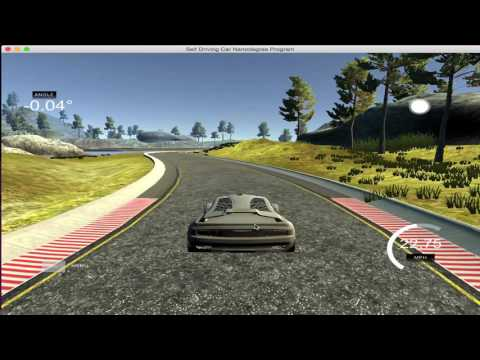

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("5tUHK5-dCb0")

### Smoother Cornering - model 5

Whilst model 4 had managed to navigate the track - it did make a pretty violent recovery at the first left habnd bend after the bridge.  I am not sure I would have felt comfortable in such a self-driving vehicle!  I hypothesized that maybe my choice of binning threshold could be responsible for this - perhaps upweighting very extreme angles too much - leading to late recovery rather than gradual recovery.  I tried retraining with different bins.  

However my initial experiment made little impact.  I also experimented with dropout - in particular removing dropout entirely.  I got the smoothest driving by removing dropout and by changing the distribution of the bins to :  (-inf, < -0.5], (-0.5, -0.3], (-0.3, -0.1], (-0.1, 0.1], (0.1, 0.3], (0.3, 0.5], (0.5, inf).

Here is my final model performance:

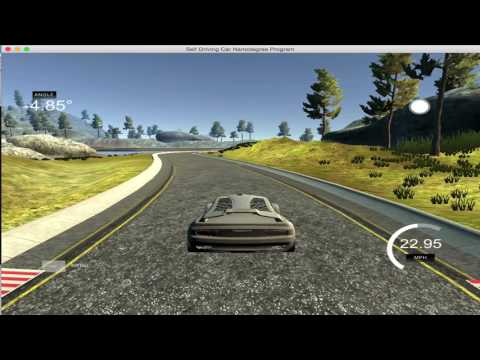

In [3]:
YouTubeVideo("SnZaafoMqZc")

I suspect that the smoother driving when I removed dropout could be highlighting that that my model is either undertrained or has too small an architecture.  Further experiments would be required to ascertain the root cause - I would start by increasing the size of the fully connected layer and the convolutional layers.

### Lessons Learnt

* MSE not particularly helpful - nor was early stopping.  Heavy dropout combined with image augmentation was the most effective for my training data.  I was surprised how early stopping (my go to regularisation technique!) did not help - I think this is most likely because the training data was small relative to the model parameters - so high variance to training/ validation randomisation.  Maybe with augmentation will be a lot better.
* I should have spent more time initially understanding the distribution of the training data.  Initially I did not plot the distribution of the angles - I should have gone straight to the data and checked that the data balance across the steering angles.  Initially I relied too much on the collection of training data created by driving forwards and backwards around the track.  This balanced the angles but the small steering angles still dominated the recovery data - in hindsight this seems obvious but it wasted several rounds of experiments over a number of weeks!
* I was reluctant to implement image augmentation since it introduced yet more hyperparameters.  However this was the break through for me and got me reliably over the bridge and then round the track.  This is the first time I have been in a position to generate more training data - in my previous applications of machine learnign I have a fixed data set - often collected at great expense. It was an odd feeling to be able to cheaply create more data.  A great lesson from this project.
* At times it was daunting to confront the number of hyper-parameters.  For example the model architecture, learning rate, image augmentation parameters, amount of training data, test/ valid split.  In the end I had to go with my gut feel - lifting an architecture from this paper and just fixing my learning rate using the Adam optimizer.  Turns out that so long as these are sensible that they are second order to the data itself.   

My final thoughts relate to the choice of training error.  I have seen the out of sample validation MSE was not a useful metric.  I wonder if there is a way to better train these models - for example evaluating on a series of correlated images and assessing deviation from the center

### Rubric

#### Quality of Code
Criteria 	Meets Specifications

Is the code functional?
	
The model provided can be used to successfully operate the simulation.

Is the code usable and readable?
	
The code in model.py uses a Python generator, if needed, to generate data for training rather than storing the training data in memory. The model.py code is clearly organized and comments are included where needed.

#### Model Architecture and Training Strategy

Criteria 	Meets Specifications

Has an appropriate model architecture been employed for the task?
	
The neural network uses convolution layers with appropriate filter sizes. Layers exist to introduce nonlinearity into the model. The data is normalized in the model.

Has an attempt been made to reduce overfitting of the model?

Train/validation/test splits have been used, and the model uses dropout layers or other methods to reduce overfitting.

Have the model parameters been tuned appropriately?

Learning rate parameters are chosen with explanation, or an Adam optimizer is used.

Is the training data chosen appropriately?
	
Training data has been chosen to induce the desired behavior in the simulation (i.e. keeping the car on the track).

#### Architecture and Training Documentation

Criteria 	Meets Specifications

Is the solution design documented?
	
The README thoroughly discusses the approach taken for deriving and designing a model architecture fit for solving the given problem.

Is the model architecture documented?
	
The README provides sufficient details of the characteristics and qualities of the architecture, such as the type of model used, the number of layers, the size of each layer. Visualizations emphasizing particular qualities of the architecture are encouraged.

Is the creation of the training dataset and training process documented?
	
The README describes how the model was trained and what the characteristics of the dataset are. Information such as how the dataset was generated and examples of images from the dataset should be included.

#### Simulation

Criteria 	Meets Specifications

Is the car able to navigate correctly on test data?
	
No tire may leave the drivable portion of the track surface. The car may not pop up onto ledges or roll over any surfaces that would otherwise be considered unsafe (if humans were in the vehicle).